<a href="https://colab.research.google.com/github/ChenChingChih/DeepLearningProject/blob/master/GRU_predicting_unemployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# GRU predicting unemployment
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime

torch.manual_seed(42)


In [0]:
class GRUCell(nn.Module):
    """
    An implementation of GRUCell.

    """

    def __init__(self, input_size, hidden_size, bias=True):
        # input_size = dimension of x[t]
        # hidden_size = dimension of h[t]
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)   # r
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)  # z
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):
        # x: x[t]
        # hidden: h[t-1]
        x = x.view(-1, x.size(1))

        gate_x = self.x2h(x)    # r
        gate_h = self.h2h(hidden)   # z

        gate_x = gate_x.squeeze()   # r
        gate_h = gate_h.squeeze()   # z

        i_r, i_i, i_n = gate_x.chunk(3, 1)   # (r, z, g) from x
        h_r, h_i, h_n = gate_h.chunk(3, 1)   # (r, z, g) from h

        resetgate = torch.sigmoid(i_r + h_r)  # r
        inputgate = torch.sigmoid(i_i + h_i)  # z
        newgate = torch.tanh(i_n + (resetgate * h_n))   # g

        hy = newgate + inputgate * (hidden - newgate)

        return hy



In [0]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(GRUModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim
        self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        outs = []
        hn = h0[0, :, :]

        # calculate GRU cell for all t
        for seq in range(x.size(1)):
            hn = self.gru_cell(x[:, seq, :], hn)
            outs.append(hn)

        out = outs[-1].squeeze()

        # out: y[t] = f(h[t])
        out = self.fc(out)
        return out

epoch:  49 loss:  0.02039489895105362
epoch:  99 loss:  0.008956346660852432
epoch:  149 loss:  0.003991500474512577
epoch:  199 loss:  0.0025061198975890875
epoch:  249 loss:  0.0021422042045742273
epoch:  299 loss:  0.0020452039316296577
epoch:  349 loss:  0.0020028783474117517
epoch:  399 loss:  0.0019712629728019238
epoch:  449 loss:  0.0019419715972617269
epoch:  499 loss:  0.0019134556641802192
epoch:  549 loss:  0.0018854282097890973
epoch:  599 loss:  0.0018578303279355168
epoch:  649 loss:  0.0018306456040591002
epoch:  699 loss:  0.0018038646085187793
epoch:  749 loss:  0.0017774800071492791
epoch:  799 loss:  0.0017514849314466119
epoch:  849 loss:  0.0017258747247979045
epoch:  899 loss:  0.0017006427515298128
epoch:  949 loss:  0.0016757845878601074
epoch:  999 loss:  0.0016512961592525244
epoch:  1049 loss:  0.0016271728090941906
epoch:  1099 loss:  0.0016034113941714168
epoch:  1149 loss:  0.001580009120516479
epoch:  1199 loss:  0.001556962262839079
epoch:  1249 loss:  

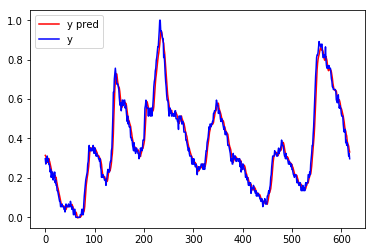

In [0]:
if __name__ == '__main__':
    start = datetime.datetime(1963, 1, 1)
    end = datetime.date(2014, 12, 31)
    df_orig = web.DataReader('UNRATE', 'fred', start, end)
    u = df_orig.UNRATE.values
    scale = u.max() - u.min()
    d = (u - u.min()) / scale  # convert data to [0, 1]
    rng = pd.date_range('1/1/1963', periods=u.shape[0], freq='M')
    df = pd.DataFrame(d, columns=['UNRATE'], index=rng)
    n_lag = 6
    f_ahead = 1
    total_shift = n_lag + f_ahead - 1
    for i in range(1, total_shift + 1):
        df['u_lag' + str(i)] = pd.Series(df.UNRATE.shift(i), index=df.index)
    df.dropna(inplace=True)

    dataset = df.values
    train_size = int(dataset.shape[0] * 0.7)
    test_size = dataset.shape[0] - train_size
    data_Y = dataset[:, 0]  # y[t]
    data_X = dataset[:, f_ahead:]  # y[t-f_ahead], ..., y[t-total_shift]
    Y_train = data_Y[:train_size]
    Y_test = data_Y[train_size:]
    X_train = data_X[:train_size]
    X_test = data_X[train_size:]

    input_dim = n_lag
    hidden_dim = 20
    layer_dim = 1  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
    output_dim = 1

    myModel = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)
    myLoss = nn.MSELoss()
    learning_rate = 0.1
    optimizer = torch.optim.SGD(myModel.parameters(), lr=learning_rate)

    train_X = X_train.reshape(-1, 1, n_lag)
    train_Y = Y_train.reshape(-1, 1, 1)
    test_X = X_test.reshape(-1, 1, n_lag)

    train_x = torch.tensor(train_X).float()
    train_y = torch.tensor(train_Y).float()
    test_x = torch.tensor(test_X).float()

    epochs = 2000
    for i in range(epochs):
        # foward propagation
        out = myModel(train_x)

        # compute the loss
        loss = myLoss(train_y[:, 0, :], out)
        if (i + 1) % 50 == 0:
            print('epoch: ', i, 'loss: ', loss.item())

        # zero the gradients
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()

    myModel = myModel.eval()
    data_X = data_X.reshape(-1, 1, n_lag)
    data_X = torch.tensor(data_X).float()
    var_data = data_X   # Variable(data_X)
    pred_test = myModel(var_data)
    pred_test = pred_test.view(-1).data.numpy()

    plt.figure(0)
    plt.clf()
    plt.plot(pred_test, 'r', label='y pred')
    plt.plot(data_Y, 'b', label='y')
    plt.legend()
    plt.show()
